# Time series analysis with HyP3 and MintPy

This notebook walks through performing a time-series analysis of the 2019 Ridgecrest, CA earthquake with On Demand InSAR products from the Alaska Satellite facility and MintPy. We'll:

1. Use the [ASF Search Python package](https://docs.asf.alaska.edu/asf_search/basics/) to:
   - Search ASF's catalog for Sentinel-1 SAR products covering the [Ridgecrest earthquake](https://earthquake.usgs.gov/storymap/index-ridgecrest.html)
   - Select a reference scene to generate a baseline stack
   - Select a [short baseline subset (SBAS)](https://docs.asf.alaska.edu/vertex/sbas/) of scene pairs for InSAR processing


2. Use the [HyP3 Python SDK](https://hyp3-docs.asf.alaska.edu/using/sdk/) to:
   - Request On Demand InSAR products from ASF HyP3
   - Download the InSAR products when they are done processing


3. Use [GDAL](https://gdal.org/api/index.html#python-api) and [MintPy](https://mintpy.readthedocs.io/en/latest/) to:
   - Prepare the InSAR products for MintPy
   - perform a time-series analysis with MintPy
   
---

**Note:** This notebook does assume you have some familiarity with InSAR processing with MintPy already, and is a minimal example without much context or explanations. If you're new to InSAR and MintPy, I suggest checking out:
* our [InSAR on Demand Story Map](https://storymaps.arcgis.com/stories/68a8a3253900411185ae9eb6bb5283d3)


* [OpenSARlab's](https://opensarlab-docs.asf.alaska.edu/) highly detailed walkthrough of using HyP3 + MintPy via these notebooks:
  * [Prepare a HyP3 InSAR Stack for MintPy](https://nbviewer.org/github/ASFOpenSARlab/opensarlab-notebooks/blob/master/SAR_Training/English/Master/Prepare_HyP3_InSAR_Stack_for_MintPy.ipynb)
  * [MintPy Time-series Analysis](https://nbviewer.org/github/ASFOpenSARlab/opensarlab-notebooks/blob/master/SAR_Training/English/Master/MintPy_Time_Series_From_Prepared_Data_Stack.ipynb)
  
    Note: While these notebooks make some assumptions you're working in OpenSARlab, you can run these 
    notebooks outside OpenSARlab by creating [this conda environment](https://github.com/ASFOpenSARlab/opensarlab-envs/blob/main/Environment_Configs/insar_analysis_env.yml).

## 0. Initial Setup

To run this notebook, you'll need a conda environment with the required dependencies. You can set up a new environment (recommended) and run the jupyter server like:
```shell
conda create -n hyp3-mintpy python=3.10 asf_search hyp3_sdk "mintpy>=1.3.2" pandas jupyter ipympl

conda activate hyp3-mintpy
jupyter notebook hyp3_insar_stack_for_ts_analysis.ipynb
```
Or, install these dependencies into your own environment:
```shell
conda install hyp3-mintpy python=3.10 asf_search hyp3_sdk "mintpy>=1.3.2" pandas jupyter ipympl

jupyter notebook hyp3_insar_stack_for_ts_analysis.ipynb
```

In [44]:

from pathlib import Path

from dateutil.parser import parse as parse_date


### Set parameters

In [45]:

project_name = '2019_ridgecrest'
work_dir = Path.cwd() / project_name
data_dir = work_dir / 'data'

stack_start = parse_date('2019-06-10 00:00:00Z')
stack_end = parse_date('2019-07-21 00:00:00Z')
max_temporal_baseline = 13 #days

data_dir.mkdir(parents=True, exist_ok=True)


## 1. Select InSAR pairs with ASF Search

In [ ]:

import asf_search as asf
import pandas as pd

search_results = asf.geo_search(
        platform=asf.SENTINEL1,
        intersectsWith='POINT(-117.599330 35.769500)',
        start='2019-06-10',
        end='2019-07-21',
        processingLevel=asf.SLC,
        beamMode=asf.IW,
        flightDirection=asf.ASCENDING,
    )


In [ ]:

baseline_results = asf.baseline_search.stack_from_product(search_results[-1])

columns = list(baseline_results[0].properties.keys()) + ['geometry', ]
data = [list(scene.properties.values()) + [scene.geometry, ] for scene in baseline_results]

stack = pd.DataFrame(data, columns=columns)
stack['startTime'] = stack.startTime.apply(parse_date)

stack = stack.loc[(stack_start <= stack.startTime) & (stack.startTime <= stack_end)]


In [ ]:

sbas_pairs = set()

for reference, rt in stack.loc[::-1, ['sceneName', 'temporalBaseline']].itertuples(index=False):
    secondaries = stack.loc[
        (stack.sceneName != reference)
        & (stack.temporalBaseline - rt <= max_temporal_baseline)
        & (stack.temporalBaseline - rt > 0)
    ]
    for secondary in secondaries.sceneName:
        sbas_pairs.add((reference, secondary))


## 2. Request On Demand InSAR products from ASF HyP3

Use your [NASA Earthdata login](https://urs.earthdata.nasa.gov/) to connect to [ASF HyP3](https://hyp3-docs.asf.alaska.edu/).

In [ ]:

import hyp3_sdk as sdk

hyp3 = sdk.HyP3(prompt=True)


In [ ]:

jobs = sdk.Batch()
for reference, secondary in sbas_pairs:
    jobs += hyp3.submit_insar_job(reference, secondary, name=project_name,
                                  include_dem=True, include_look_vectors=True)


In [ ]:

jobs = hyp3.watch(jobs)


In [ ]:

jobs = hyp3.find_jobs(name=project_name)


In [ ]:

insar_products = jobs.download_files(data_dir)
insar_products = [sdk.util.extract_zipped_product(ii) for ii in insar_products]


## 3. Time-series Analysis with MintPy

### 3.1 Subset all GeoTIFFs to their common overlap

In [46]:
from pathlib import Path
from typing import List, Union
from osgeo import gdal


def get_common_overlap(file_list: List[Union[str, Path]]) -> List[float]:
    """Get the common overlap of  a list of GeoTIFF files
    
    Arg:
        file_list: a list of GeoTIFF files
    
    Returns:
         [ulx, uly, lrx, lry], the upper-left x, upper-left y, lower-right x, and lower-right y
         corner coordinates of the common overlap
    """
    
    corners = [gdal.Info(str(dem), format='json')['cornerCoordinates'] for dem in file_list]

    ulx = max(corner['upperLeft'][0] for corner in corners)
    uly = min(corner['upperLeft'][1] for corner in corners)
    lrx = min(corner['lowerRight'][0] for corner in corners)
    lry = max(corner['lowerRight'][1] for corner in corners)
    return [ulx, uly, lrx, lry]


In [47]:

files = data_dir.glob('*/*_dem.tif')

overlap = get_common_overlap(files)


In [48]:

from pathlib import Path
from typing import List, Union

def clip_hyp3_products_to_common_overlap(data_dir: Union[str, Path], overlap: List[float]) -> None:
    """Clip all GeoTIFF files to their common overlap
    
    Args:
        data_dir:
            directory containing the GeoTIFF files to clip
        overlap:
            a list of the upper-left x, upper-left y, lower-right-x, and lower-tight y
            corner coordinates of the common overlap
    Returns: None
    """

    
    files_for_mintpy = ['_water_mask.tif', '_corr.tif', '_unw_phase.tif', '_dem.tif', '_lv_theta.tif', '_lv_phi.tif']

    for extension in files_for_mintpy:

        for file in data_dir.rglob(f'*{extension}'):

            dst_file = file.parent / f'{file.stem}_clipped{file.suffix}'

            gdal.Translate(destName=str(dst_file), srcDS=str(file), projWin=overlap)


In [49]:

clip_hyp3_products_to_common_overlap(data_dir, overlap)


### 3.2 Create the MintPy config file

In [52]:

mintpy_config = work_dir / 'mintpy_config.txt'
mintpy_config.write_text(
f"""
mintpy.load.processor        = hyp3
##---------interferogram datasets:
mintpy.load.unwFile          = {data_dir}/*/*_unw_phase_clipped.tif
mintpy.load.corFile          = {data_dir}/*/*_corr_clipped.tif
##---------geometry datasets:
mintpy.load.demFile          = {data_dir}/*/*_dem_clipped.tif
mintpy.load.incAngleFile     = {data_dir}/*/*_lv_theta_clipped.tif
mintpy.load.azAngleFile      = {data_dir}/*/*_lv_phi_clipped.tif
mintpy.load.waterMaskFile    = {data_dir}/*/*_water_mask_clipped.tif
##----------troposphere correction
mintpy.troposphericDelay.method = no
""")


982

### 3.3 run MintPy to do the time series analysis

In [53]:

!smallbaselineApp.py --dir {work_dir} {mintpy_config}



___________________________________________________________

  /##      /## /##             /##     /#######
 | ###    /###|__/            | ##    | ##__  ##
 | ####  /#### /## /#######  /######  | ##  \ ## /##   /##
 | ## ##/## ##| ##| ##__  ##|_  ##_/  | #######/| ##  | ##
 | ##  ###| ##| ##| ##  \ ##  | ##    | ##____/ | ##  | ##
 | ##\  # | ##| ##| ##  | ##  | ## /##| ##      | ##  | ##
 | ## \/  | ##| ##| ##  | ##  |  ####/| ##      |  #######
 |__/     |__/|__/|__/  |__/   \___/  |__/       \____  ##
                                                 /##  | ##
                                                |  ######/
   Miami InSAR Time-series software in Python    \______/
          MintPy 1.3.0.post339, 2023-05-25
___________________________________________________________

--RUN-at-2023-08-18 10:17:17.184821--
Current directory: /home/jiangzhu/projects/work/hyp3/hyp3-docs/docs/tutorials
Run routine processing with smallbaselineApp.py on steps: ['load_data', 'modify_network', '

In [54]:

%matplotlib widget
from mintpy.cli import view, tsview


run view.py in MintPy version 1.3.0.post339, date 2023-05-25
input file is velocity file: /home/jiangzhu/projects/work/hyp3/hyp3-docs/docs/tutorials/2019_ridgecrest/velocity.h5 in float32 format
file size in y/x: (2123, 3479)
num of datasets in file velocity.h5: 5
datasets to exclude (0):
[]
datasets to display (5):
['velocity', 'velocityStd', 'intercept', 'interceptStd', 'residue']
data   coverage in y/x: (0, 0, 3479, 2123)
subset coverage in y/x: (0, 0, 3479, 2123)
data   coverage in lat/lon: (279200.0, 4087840.0, 557520.0, 3918000.0)
subset coverage in lat/lon: (279200.0, 4087840.0, 557520.0, 3918000.0)
------------------------------------------------------------------------
colormap: jet
figure title: velocity
figure size : [15.00, 8.00]
dataset number: 5
row     number: 2
column  number: 3
figure  number: 1
read mask from file: maskTempCoh.h5
----------------------------------------
Figure 1 - velocity.png
reading data as a list of 2D matrices ...
[================================

/home/jiangzhu/projects/work/hyp3/MintPy/src/mintpy/view.py:1346: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


showing ...


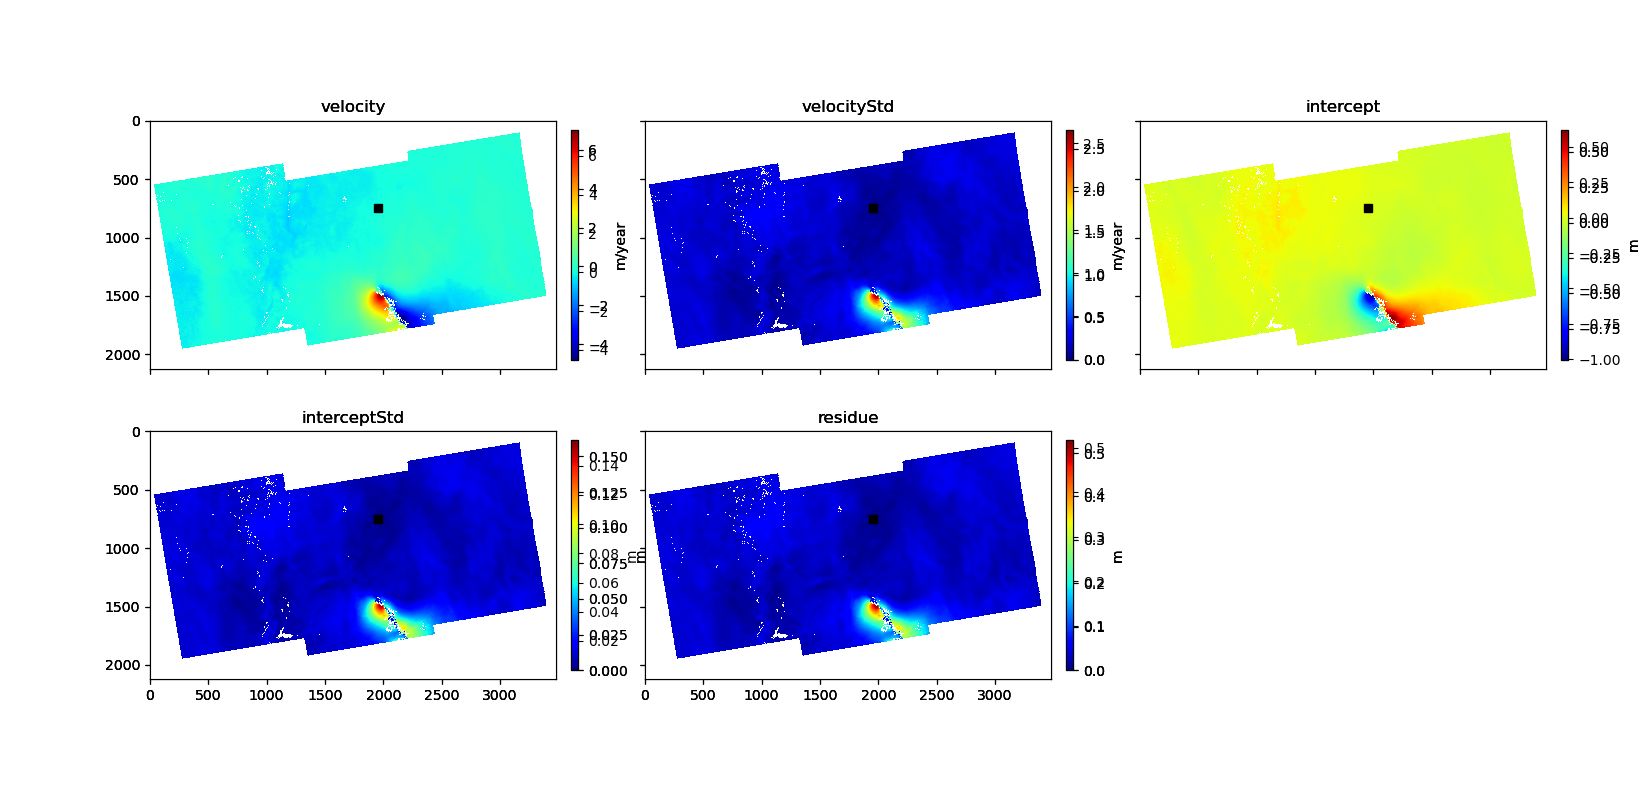

In [55]:

view.main([f'{work_dir}/velocity.h5'])


tsview.py /home/jiangzhu/projects/work/hyp3/hyp3-docs/docs/tutorials/2019_ridgecrest/timeseries.h5
open timeseries file: timeseries.h5
No lookup table (longitude or rangeCoord) found in files.
data   coverage in y/x: (0, 0, 3479, 2123)
subset coverage in y/x: (0, 0, 3479, 2123)
data   coverage in lat/lon: (279200.0, 4087840.0, 557520.0, 3918000.0)
subset coverage in lat/lon: (279200.0, 4087840.0, 557520.0, 3918000.0)
------------------------------------------------------------------------
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    stepDate   : []
    polyline   : []
    exp        : {}
    log        : {}
reading timeseries from file /home/jiangzhu/projects/work/hyp3/hyp3-docs/docs/tutorials/2019_ridgecrest/timeseries.h5
reference to date: 20190716
read mask from file: maskTempCoh.h5
data    range: [-84.828125, 53.435802] cm
display range: [-82.55604, 51.42676] cm
create figure for map in size of [10.0, 5.6]
display 

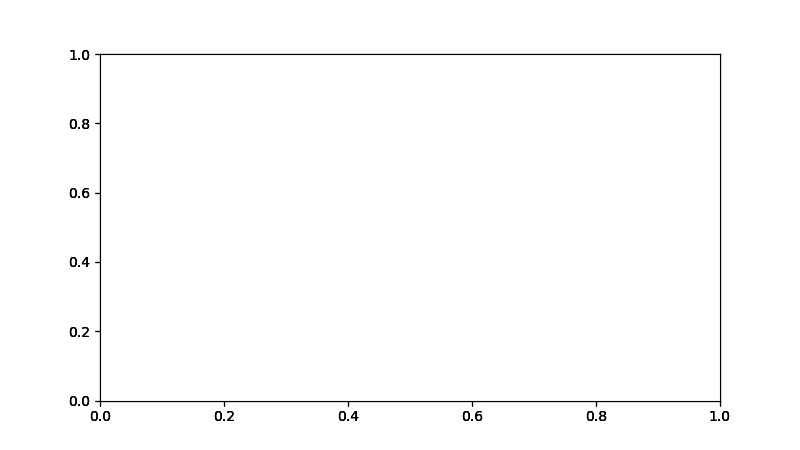

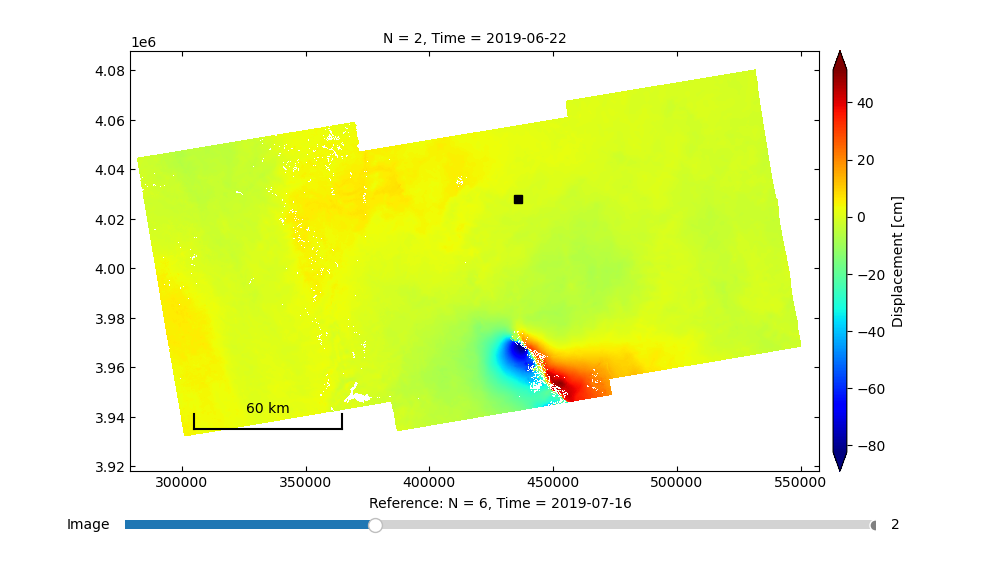

In [56]:

tsview.main([f'{work_dir}/timeseries.h5'])
